In [1]:
%pylab inline
import openwpm
from spark_uid import *

Populating the interactive namespace from numpy and matplotlib


## Load crawl db

In [2]:
openwpm_log_dir = '/Users/sammacbeth/data/openwpm/crawl_20170309/'
crawldb = openwpm.load_crawl_db(openwpm_log_dir)
crawls = {}
for cid, params in openwpm.get_crawls(crawldb):
    crawls[cid] = {
        "config": openwpm.filtered_config(params),
        "urls": openwpm.get_crawled_urls(crawldb, cid)
    }
    print(cid, crawls[cid]["config"])
    print('urls crawled:', len(crawls[cid]["urls"]))

1 {'tp_cookies': 'always', 'https-everywhere': False, 'cliqz': False, 'privacy-badger': False, 'adblock-plus': False, 'ghostery': False, 'donottrack': False}
urls crawled: 788
2 {'tp_cookies': 'always', 'https-everywhere': False, 'cliqz': True, 'privacy-badger': False, 'adblock-plus': False, 'ghostery': False, 'donottrack': False}
urls crawled: 787
3 {'tp_cookies': 'always', 'https-everywhere': False, 'cliqz': False, 'privacy-badger': False, 'adblock-plus': False, 'ghostery': True, 'donottrack': False}
urls crawled: 788


## Load request data

In [3]:
crawl_ids = crawls.keys()

def sanitise_request_obj(req):
    req['found_urls'] = list(req['found_urls'])
    return req

def load_requests(crawl_id):
    return load_mitm_data(sc, input_dir=openwpm_log_dir + str(crawl_id) + '/').map(sanitise_request_obj)

crawl_requests = {k: load_requests(k) for k in crawl_ids}

### Compare number of requests for each crawl

In [4]:
{k: req.count() for k, req in crawl_requests.items()}

{1: 45245, 2: 26301, 3: 41044}

In [5]:
def get_response_header(req, header):
    cl_headers = [h[1] for h in filter(lambda h: h[0] == header, req.get('res_headers', []))]
    return cl_headers[0] if len(cl_headers) > 0 else None

def get_content_length(req):
    cl = get_response_header(req, "Content-Length")
    if cl is not None:
        return int(cl) / 1048576.
    else:
        return 0

{k: req.map(get_content_length).sum() for k, req in crawl_requests.items()}

{1: 684.4185161590576, 2: 637.5861310958862, 3: 1020.6599559783936}

### Check that we actually saw requests to the crawl URLS (i.e. the proxy was working correctly)

In [6]:
from urllib.parse import urlparse

def crawl_url_occurance(requests, crawl_urls):
    crawl_hosts = set([urlparse(u).netloc for u in crawl_urls])
    return requests.map(lambda r: r['host']).filter(lambda h: h in crawl_hosts).distinct().count()

{cid: crawl_url_occurance(crawl_requests[cid], crawls[cid]["urls"]["site_url"]) for cid in crawl_ids}

{1: 450, 2: 215, 3: 626}

### Request count per domain

In [7]:
# requests by host
import pandas as pd
from operator import add, itemgetter

def requests_by_host(i):
    return crawl_requests[i].map(lambda r: (r['host'], 1)).reduceByKey(add).mapValues(lambda v: {i: v})

def merge_dicts(a, b):
    a.update(b)
    return a

rows = sc.union([requests_by_host(cid) for cid in crawl_ids])\
    .reduceByKey(lambda a, b: merge_dicts(a, b)).sortBy(lambda x: sum(list(x[1].values())), ascending=False)\
    .map(lambda row: {"domain": row[0], **row[1]}).take(30)

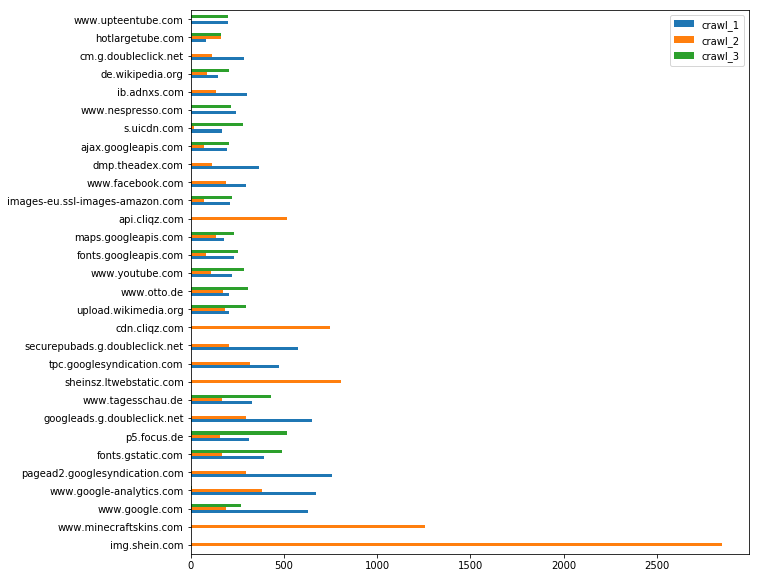

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
plt.figure(figsize=(200,100))
df = pd.DataFrame({'crawl_{}'.format(k): [r[k] if k in r else 0 for r in rows] for k in crawl_ids}, index=[r['domain'] for r in rows])
df.plot.barh()

### Request size per domain

In [9]:
def size_by_host(i):
    return crawl_requests[i].map(lambda r: (r['host'], get_content_length(r))).reduceByKey(add).mapValues(lambda v: {i: v})

rows = sc.union([size_by_host(cid) for cid in crawl_ids])\
    .reduceByKey(lambda a, b: merge_dicts(a, b)).sortBy(lambda x: sum(list(x[1].values())), ascending=False)\
    .map(lambda row: {"domain": row[0], **row[1]}).take(30)

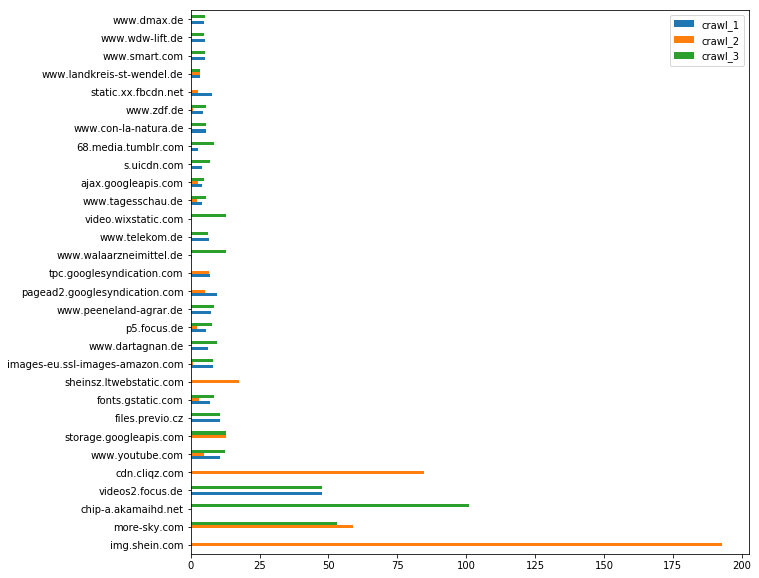

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
plt.figure(figsize=(200,100))
df = pd.DataFrame({'crawl_{}'.format(k): [r[k] if k in r else 0 for r in rows] for k in crawl_ids}, index=[r['domain'] for r in rows])
df.plot.barh()

## Look for UIDs

In [11]:
def get_crawled_urls(cid):
    crawl_list = set(crawls[cid]["urls"]["site_url"])
    urls = set(["{}/".format(u) for u in crawl_list if u[-1] != '/'] + list(crawl_list))
    redirected_urls = crawl_requests[cid].filter(lambda r: r['url'] in urls).filter(lambda r: r["res_status"] > 300)\
        .map(lambda r: get_response_header(r, "Location")).filter(lambda u: u is not None).collect()
    return urls.union(redirected_urls)

In [12]:
def analyse(requests, visited):
    linked = link_requests_by_uid(requests).cache()
    uid_reach = calculate_uid_reach(requests, linked)
    return uid_reach_as_dataframes(uid_reach, sqlContext, visited_domains=visited)

analysed_crawls = {cid: analyse(crawl_requests[cid], 
                           set([urlparse(u).netloc for u in crawls[cid]["urls"]["site_url"]])) for cid in crawl_ids}

In [13]:
from urllib.parse import unquote
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

def reduce_uids(rows):
    combi_qs = ["{}={}".format(r.key, r.value) for r in rows]
    return len(combi_qs), '&'.join(combi_qs)

def get_reduced_tracking_list(cid):
    # get full list of urls visited in the crawl
    crawled_urls = get_crawled_urls(cid)
    
    # create udf to check if a url was crawled
    def contains_crawled_url(url):
        decoded_url = unquote(url)
        for curl in crawled_urls:
            if curl in url or curl in decoded_url:
                return curl
        return None
    
    is_crawl_url = udf(contains_crawled_url, StringType())
    # this is the table of urls from the crawl we found for each uid
    bad_uniques = analysed_crawls[cid]["uniques_seen"]\
        .withColumn('crawl_url', is_crawl_url(analysed_crawls[cid]["uniques_seen"].url))\
        .where(col('crawl_url').isNotNull())
    
    # these are key/value pairs classified as uids by the analysis
    bad_uids = sqlContext.createDataFrame(analysed_crawls[cid]["uid_parts"]\
        .where('classification = "uid"').sort('key').rdd.map(lambda row: (row.uid_id, row))\
        .groupByKey().mapValues(reduce_uids)\
        .map(lambda t: Row(uid_id=t[0], uid_length=t[1][0], bad_uid=t[1][1])))
    
    # count session size seen by each uid
    uniques = bad_uniques.select('uid_id', 'crawl_url').distinct().groupBy('uid_id').count()\
        .withColumnRenamed('count', 'session_size')
        
    # add extra tables to crawls data
    analysed_crawls[cid]["bad_uniques"] = bad_uniques
    analysed_crawls[cid]["bad_uids"] = bad_uids
        
    # join everything to get the master uid table
    master_uids = analysed_crawls[cid]["uid"].join(bad_uids, 'uid_id')\
        .join(uniques, 'uid_id')\
        .where('uid_length > 0').where('session_size > 0')
    # finally, dedup repeated entries
    return master_uids.sort('session_size', ascending=False).dropDuplicates(['domain', 'bad_uid'])\
        .sort('session_size', ascending=False).cache()
        
uid_rankings = {cid: get_reduced_tracking_list(cid) for cid in crawl_ids}

In [17]:
uid_rankings[1].where('session_size > 5')\
    .select('domain', 'duration', 'uid_id', 'uid_length', 'bad_uid', 'session_size').toPandas()[:20]

,domain,duration,uid_id,uid_length,bad_uid,session_size
0,doubleclick.net,7.167621,20248,2,IDE=AHWqTUmGqThkoptV4noxJvFW-KPXgWRpOi2I-MF4JU...,237
1,doubleclick.net,7.005838,4107,3,DSID=NO_DATA&IDE=AHWqTUmGqThkoptV4noxJvFW-KPXg...,209
2,google.com,6.876170,18812,1,NID=98=Xi1tTvl5CF9GCsXEzZ_HNyQJULOyPCijWw4MwRL...,189
3,google-analytics.com,7.034842,12087,1,vp=1350x697,161
4,doubleclick.net,5.671558,10688,3,IDE=AHWqTUmGqThkoptV4noxJvFW-KPXgWRpOi2I-MF4JU...,146
5,facebook.com,6.884681,19146,1,fr=0vIgopa35dLwoZOZ2..BYv-cB...1.0.BYv-cB.,123
6,googlesyndication.com,6.614457,15949,1,__gads=ID=369f0d0524b139cf:T=1488973402:S=ALNI...,100
7,ioam.de,7.248672,5937,1,id=gc5lmf,85
8,adnxs.com,7.147455,14004,1,uuid2=1534007364624019147,70
9,google-analytics.com,7.143974,14061,1,utmwv=5.6.8,66


In [18]:
uid_rankings[2].where('session_size > 5')\
    .select('domain', 'duration', 'uid_id', 'uid_length', 'bad_uid', 'session_size').toPandas()[:20]

,domain,duration,uid_id,uid_length,bad_uid,session_size
0,google-analytics.com,6.986901,1523,1,vp=1350x704,39
1,ioam.de,7.121925,6361,1,id=gc5lmf,31
2,google-analytics.com,4.690218,4322,1,utmwv=5.6.8,26
3,doubleclick.net,4.140279,5530,1,"brdim=,,0,0,1366,0,1366,768,1366,704",18
4,xplosion.de,4.425908,2391,1,os=Linux x86_64,13
5,googlesyndication.com,4.354530,6597,1,"bs=1350,704",12
6,google-analytics.com,4.669048,3259,2,utmvp=1350x704&utmwv=5.6.8,11
7,google-analytics.com,4.241292,2823,1,vp=1366x704,10
8,revsci.net,4.275331,6400,1,asidi=GUQi77m4MW7if3svnOnOuw,10
9,wikipedia.org,4.492287,6601,2,WMF-Last-Access=08-Mar-2017&WMF-Last-Access-Gl...,9


In [19]:
uid_rankings[3].where('session_size > 5')\
    .select('domain', 'duration', 'uid_id', 'uid_length', 'bad_uid', 'session_size').toPandas()[:20]

,domain,duration,uid_id,uid_length,bad_uid,session_size
0,google.com,6.424782,4169,1,NID=98=zmTRbIvo4Do-mFybpKxdJeHeK1_VOZud1B4ivJx...,54
1,cloudflare.com,6.781932,3824,1,__cfduid=d4b0d34c2c6adba754c1cdce7de1ce4881488...,50
2,youtube.com,6.255112,6882,1,VISITOR_INFO1_LIVE=bhIB4TrE6ao,43
3,youtube.com,5.354347,2417,2,CONSENT=WP.25ddda&VISITOR_INFO1_LIVE=bhIB4TrE6ao,37
4,youtube.com,5.351037,6459,3,CONSENT=WP.25ddda&PREF=f1=50000000&f5=30&VISIT...,37
5,wikipedia.org,6.674378,6156,2,WMF-Last-Access=08-Mar-2017&WMF-Last-Access-Gl...,25
6,wikipedia.org,6.674378,133,1,WMF-Last-Access-Global=08-Mar-2017,25
7,wikipedia.org,6.674378,5759,3,GeoIP=DE:HE:Frankfurt_am_Main:50.12:8.68:v4&WM...,25
8,t-online.de,3.886431,7038,1,wetterimuni=K06412000,13
9,otto.de,5.640369,3450,4,BrowserId=99afaaf1-7e62-4864-8b27-e67695b0a6e0...,9


In [ ]:
# concat uid rankings and box plot

In [ ]:
# box plot uid entropy (x reach?)